In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from datasets import load_dataset

# Загружаем датасет IMDb
dataset = load_dataset("imdb")

# Посмотрим пример
print(dataset['train'][0])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [4]:
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Your code continues here
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = train_labels
y_test = test_labels


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Параметры модели
embedding_dim = 128
lstm_units = 64


In [7]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
model_rnn.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746356661.037265     886 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746356661.037929     886 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
import numpy as np

# Convert your data to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.8928 - loss: 0.2767 - val_accuracy: 0.8800 - val_loss: 0.2971
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.8987 - loss: 0.2582 - val_accuracy: 0.8396 - val_loss: 0.4657
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.9150 - loss: 0.2231 - val_accuracy: 0.4934 - val_loss: 2.5731


In [11]:
import numpy as np

# Ensure X_test is float32 and y_test is int32/float32
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')
test_loss_rnn, test_acc_rnn = model_rnn.evaluate(X_test, y_test)
print(f"Test Accuracy (RNN): {test_acc_rnn:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.8747 - loss: 0.5043
Test Accuracy (RNN): 0.7287


In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset


In [12]:
# Используем токенизатор от BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенизация
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=200)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Удалим ненужные столбцы и укажем формат
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [13]:
model_transformer = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

In [19]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Define metrics calculation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# 2. Training arguments (unchanged)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_strategy="steps",
    logging_steps=100,
    report_to=["tensorboard"]
)

# 3. Create trainer WITH compute_metrics
trainer = Trainer(
    model=model_transformer,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics  # This was missing
)

# 4. Now training will work
trainer.train()

# 5. Evaluation will also work
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.119800,0.383776,0.883440
1000,0.109700,0.316136,0.907240
1500,0.088200,0.310906,0.910120


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation accuracy: 0.9101


In [21]:
print(f"📊 Test Accuracy (RNN):        {test_acc_rnn:.4f}")
print(f"📊 Test Accuracy (Transformer): {eval_results['eval_accuracy']:.4f}")


📊 Test Accuracy (RNN):        0.7287
📊 Test Accuracy (Transformer): 0.9101


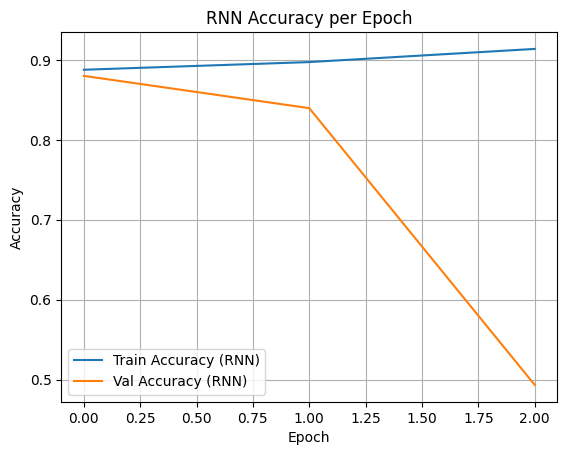

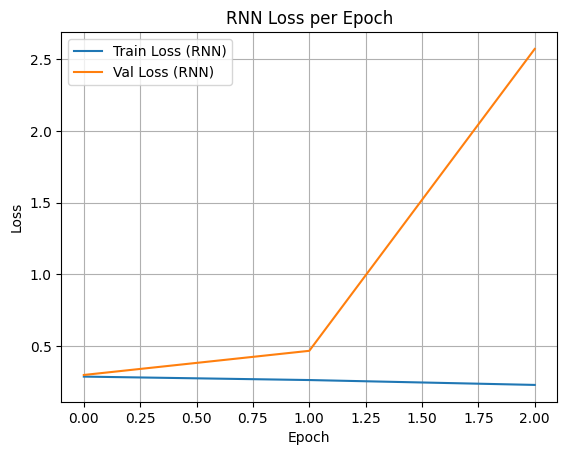

In [22]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy (RNN)')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss (RNN)')
plt.plot(history_rnn.history['val_loss'], label='Val Loss (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
